# Загружаем необходимые библиотеки

In [2]:
import os
import cv2                  
import numpy as np  
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D

from keras.layers import MaxPooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [3]:
import pandas as pd

# Проверим данные в папках

In [11]:
train_folder = r"C:\\Users\User\Python\Jora_Data\asl_alphabet\asl_alphabet_train"
all_data = []
# os.listdir(train_folder)
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    all_data += onlyfiles
train_data_df = pd.DataFrame(all_data)
train_data_df

,label,path
0,A,C:\\Users\User\Python\Jora_Data\asl_alphabet\a...
1,A,C:\\Users\User\Python\Jora_Data\asl_alphabet\a...
2,A,C:\\Users\User\Python\Jora_Data\asl_alphabet\a...
3,A,C:\\Users\User\Python\Jora_Data\asl_alphabet\a...
4,A,C:\\Users\User\Python\Jora_Data\asl_alphabet\a...
...,...,...
86995,Z,C:\\Users\User\Python\Jora_Data\asl_alphabet\a...
86996,Z,C:\\Users\User\Python\Jora_Data\asl_alphabet\a...
86997,Z,C:\\Users\User\Python\Jora_Data\asl_alphabet\a...
86998,Z,C:\\Users\User\Python\Jora_Data\asl_alphabet\a...


### Создадим тренировочную и проверочную выборку из данных. Тренировочные данные будут использоваться для оценки модели, а проверочные для поиска оптимальной точности.

In [14]:
X, X_test = train_test_split(train_data_df, test_size= 0.20, random_state=23, stratify=train_data_df[['label']])

In [15]:
X_train, X_val = train_test_split(X, test_size= 0.20, random_state=23, stratify=X[['label']])

# Извлечение изображения

### Изменим ширину и высоту, а также масштаб изображения. Функция Flow_from_Dataframe загружает изображение в память и генерирует количество данных для обучения. Создадим данные для тренировочной, проверочной и тестовой выборке.

In [16]:
img_width, img_height = 64, 64
batch_size = 256
y_col = 'label'
x_col = 'path'
no_of_classes = len(train_data_df[y_col].unique())

train_datagen = ImageDataGenerator(rescale = 1/255.0)
train_set = train_datagen.flow_from_dataframe(
    dataframe=X_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False,
)

val_datagen = ImageDataGenerator(rescale = 1/255.0)
val_set = val_datagen.flow_from_dataframe(
    dataframe=X_val, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale = 1/255.0)
test_set = test_datagen.flow_from_dataframe(
    dataframe=X_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 55680 validated image filenames belonging to 29 classes.
Found 13920 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


# Создаем модель

In [17]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(29, activation = "softmax"))

### Компилируем модель с помощью оптимизатора "Adam" и функции потерь "categorical_crossentropy".

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

### Получаем что модель должна обучить около 900тыс. параметров

### Определим остановку обучения модели, когда она 5 раз подряд не повышает точность. Также назначим число тренировочных объектов и количество эпох.

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss',patience=5)

batch_size=128
epochs=10

history = model.fit(train_set,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_set,
                    callbacks = [early_stop])

Epoch 1/10
218/218 [==============================] - 437s 2s/step - loss: 2.2389 - accuracy: 0.3334 - val_loss: 0.7397 - val_accuracy: 0.7693
Epoch 2/10
218/218 [==============================] - 268s 1s/step - loss: 0.5207 - accuracy: 0.8239 - val_loss: 0.2220 - val_accuracy: 0.9259
Epoch 3/10
218/218 [==============================] - 267s 1s/step - loss: 0.2195 - accuracy: 0.9237 - val_loss: 0.0789 - val_accuracy: 0.9792
Epoch 4/10
218/218 [==============================] - 271s 1s/step - loss: 0.1284 - accuracy: 0.9564 - val_loss: 0.0544 - val_accuracy: 0.9852
Epoch 5/10
218/218 [==============================] - 276s 1s/step - loss: 0.0884 - accuracy: 0.9695 - val_loss: 0.0323 - val_accuracy: 0.9907
Epoch 6/10
218/218 [==============================] - 270s 1s/step - loss: 0.0628 - accuracy: 0.9786 - val_loss: 0.0223 - val_accuracy: 0.9947
Epoch 7/10
218/218 [==============================] - 270s 1s/step - loss: 0.0600 - accuracy: 0.9801 - val_loss: 0.0149 - val_accuracy: 0.9959

# График точности тренировочных и проверочных данных

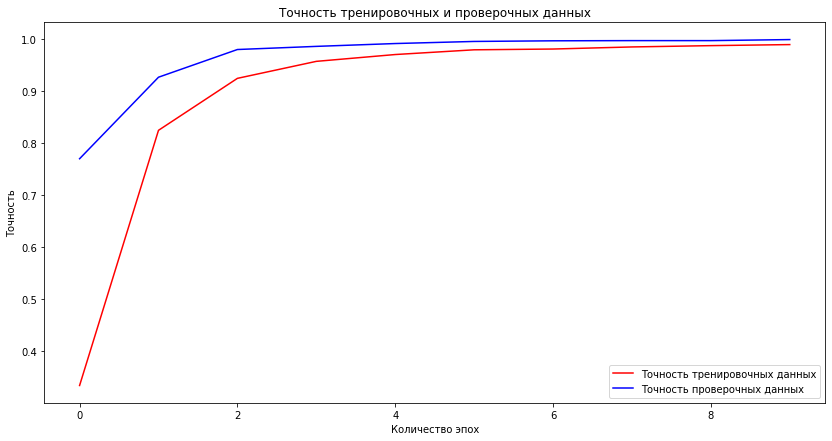

In [23]:
accur = history.history['accuracy']
val_accur = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(14,7))
plt.plot(range(len(accur)), accur, 'r', label="Точность тренировочных данных")
plt.plot(range(len(accur)), val_accur, 'b', label="Точность проверочных данных")
plt.xlabel('Количество эпох')
plt.ylabel('Точность')
plt.title('Точность тренировочных и проверочных данных')
plt.legend(loc='lower right')
plt.show()

# График функции потерь тренировочных и проверочных данных

Text(0.5, 1.0, 'Значение функции потерь тренировочных и проверочных данных')

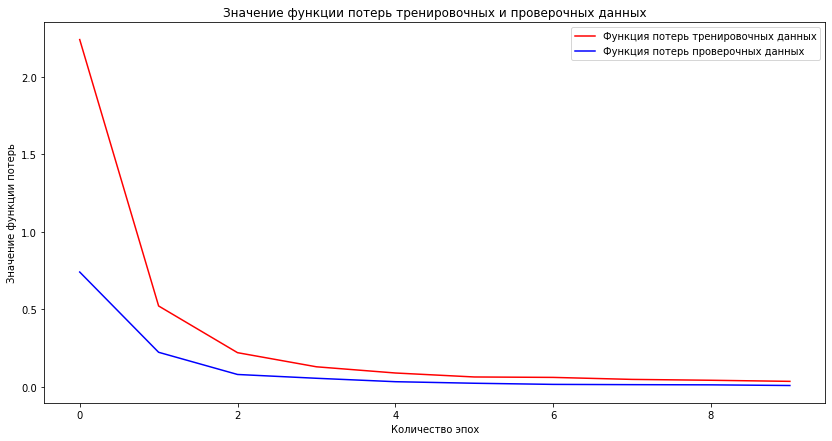

In [24]:
fig = plt.figure(figsize=(14,7))
plt.plot(range(len(accur)), loss, 'r', label="Функция потерь тренировочных данных")
plt.plot(range(len(accur)), val_loss, 'b', label="Функция потерь проверочных данных")
plt.legend(loc='upper right')
plt.xlabel('Количество эпох')
plt.ylabel('Значение функции потерь')
plt.title('Значение функции потерь тренировочных и проверочных данных')

## Предсказания

In [25]:
predictions = model.predict(test_set, verbose=1)

predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

68/68 [==============================] - 77s 1s/step
              precision    recall  f1-score   support

           A       0.99      1.00      1.00       600
           B       1.00      0.99      0.99       600
           C       1.00      1.00      1.00       600
           D       1.00      0.99      1.00       600
           E       0.99      0.99      0.99       600
           F       1.00      1.00      1.00       600
           G       1.00      1.00      1.00       600
           H       1.00      1.00      1.00       600
           I       1.00      0.99      1.00       600
           J       1.00      1.00      1.00       600
           K       0.99      1.00      1.00       600
           L       1.00      1.00      1.00       600
           M       1.00      1.00      1.00       600
           N       1.00      1.00      1.00       600
           O       1.00      0.99      1.00       600
           P       1.00      1.00      1.00       600
           Q       1.00     

### Выведем матрицу неточностей, чтобы посмотреть есть ли какие-то неправильные классификации

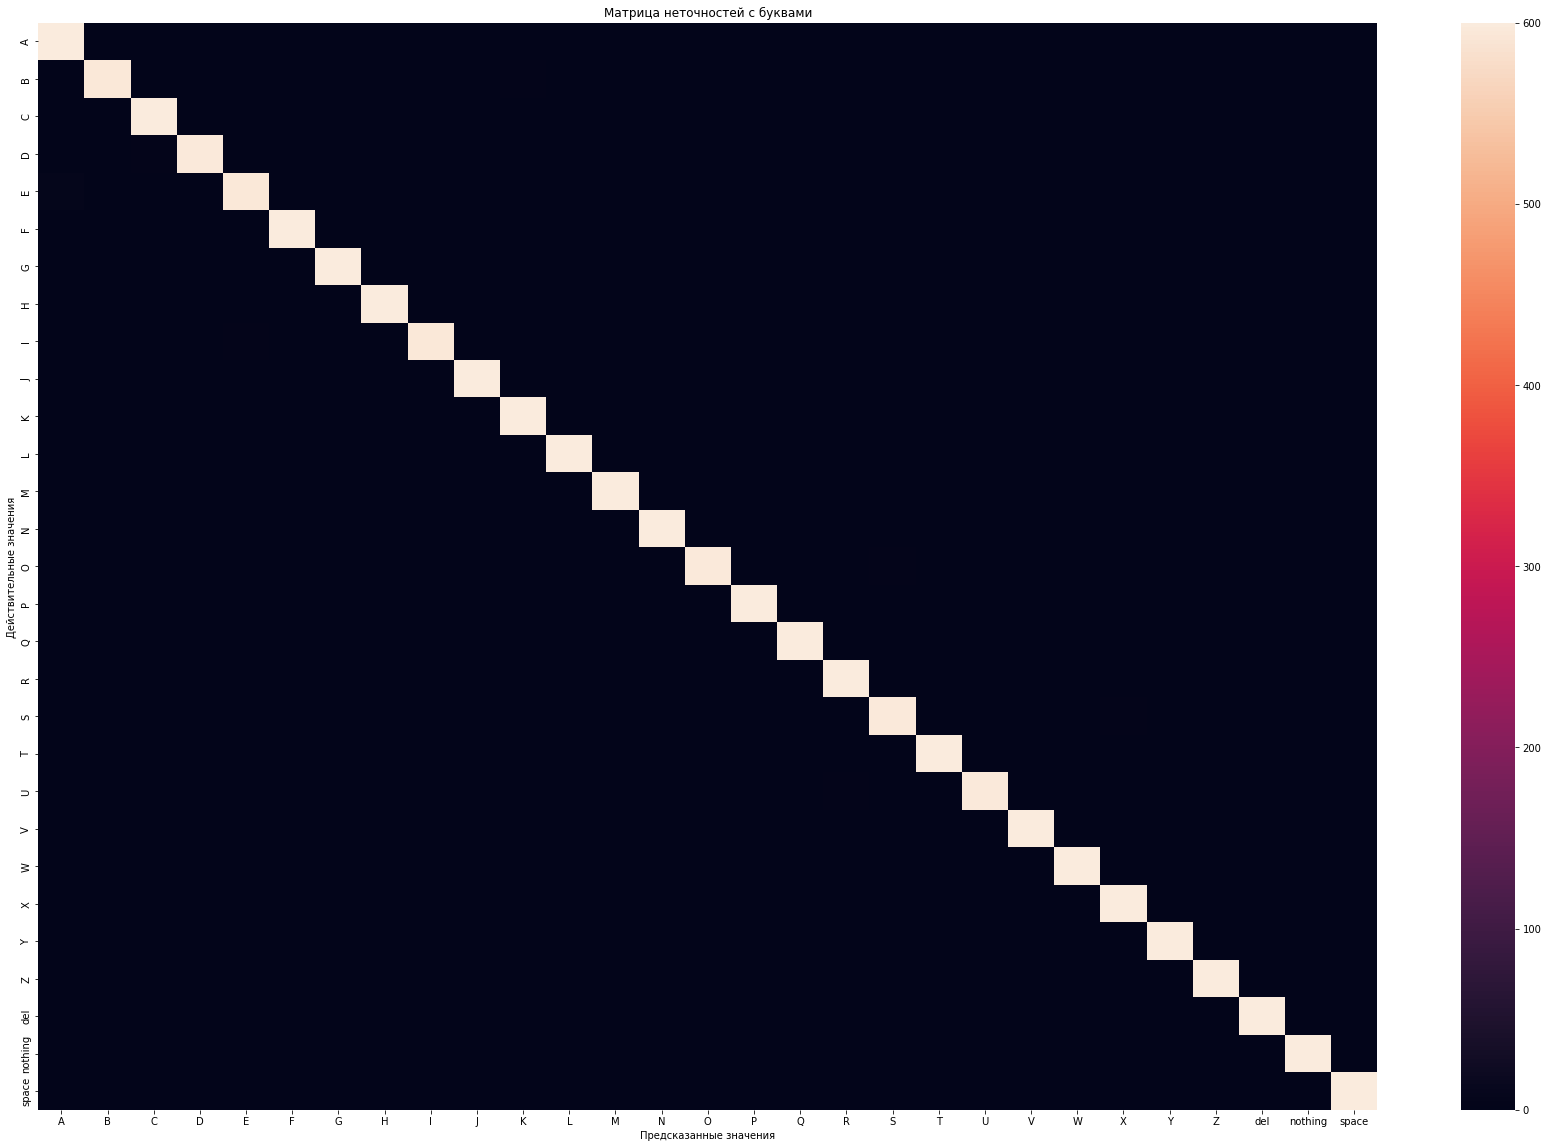

In [26]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(true_classes,predicted_classes))
ax.set_title('Матрица неточностей с буквами')
ax.set_xlabel('Предсказанные значения')
ax.set_ylabel('Действительные значения')

ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

### Сохраняем модель

In [27]:
from keras.models import model_from_json

In [31]:
model_json = model.to_json()
with open("model-bw.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights('model-bw.h5')

In [32]:
json_file = open("model-bw.json", "r")
model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(model_json)
loaded_model.load_weights("model-bw.h5")